In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib  #to save the trained model
np.random.seed(42)

df = pd.read_csv('adult.data.csv', header=None)
df.columns = [
    'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
    'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
    'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target'
]
df["Target"] = df["Target"].str.strip()

# Data overview:
print("Dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print(df.head())
print("\nData shape:",df.shape)
print("\nData info:")
print(df.info())


Dataset shape: (32561, 15)

Columns:
['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target']
   Age          Workclass  fnlwgt      Education  Education-Num  \
0   39   State-gov          77516   Bachelors                13   
1   50   Self-emp-not-inc   83311   Bachelors                13   
2   38   Private           215646   HS-grad                   9   
3   53   Private           234721   11th                      7   
4   28   Private           338409   Bachelors                13   

           Marital Status          Occupation     Relationship  \
0   Never-married           Adm-clerical        Not-in-family    
1   Married-civ-spouse      Exec-managerial     Husband          
2   Divorced                Handlers-cleaners   Not-in-family    
3   Married-civ-spouse      Handlers-cleaners   Husband          
4   Married-civ-spouse      Prof-sp

### Classifier: randomforest

======================================================= classification ==================================================

2. Analyzing target(salary) distribution...

   Target distribution (%):
Target
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64
Median age: 37.0

Binarized age distribution (%):
age_binary
0    51.229999
1    48.770001
Name: proportion, dtype: float64
Columns: ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target', 'age_binary']
Feature shape: (32561, 100)
Target shape: (32561,)
Features used: ['fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week', 'age_binary', 'Workclass_ Federal-gov     ', 'Workclass_ Local-gov       ', 'Workclass_ Never-worked    ', 'Workclass_ Private         ', 'Workclass_ Self-emp-inc    ', 'Workclass_ Self-emp-not-inc', 'Workclass_ State-gov       ', 'Workclas

['train_test_splits.joblib']

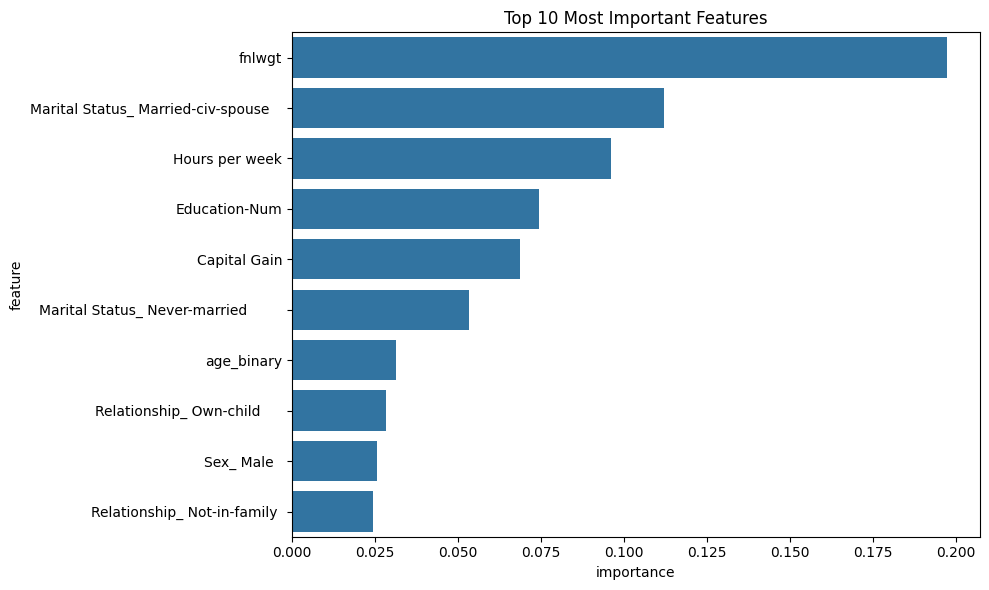

In [ ]:
print("="*55,"classification","="*50)
# Target distribution
print("\n2. Analyzing target(salary) distribution...")
print("\n   Target distribution (%):")
target_dist = df['Target'].value_counts(normalize=True) * 100
print(target_dist)

#Binarize Age
median_age = df['Age'].median()
df['age_binary'] = (df['Age'] > median_age).astype(int)
print(f"Median age: {median_age}")
print("\nBinarized age distribution (%):")
print(df['age_binary'].value_counts(normalize=True) * 100)

#data preparation
df_clean = df.copy()

print(f"Columns: {df_clean.columns.tolist()}")

# Prepare features and target cols
numerical_features = ['Education-Num', 'Hours per week', 'Capital Gain', 'Capital Loss']
categorical_features = ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
# one hot encore categorical
df_encoded = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True)
df_encoded = df_encoded.drop(columns=['Age'])
df_encoded = df_encoded.rename(columns=lambda x: x.strip())
# feature matrix X
X = df_encoded.drop('Target', axis=1)
X['age_binary'] = df['age_binary'] 
# target 1 if >50K else 0
y = (df_clean['Target'] == '>50K').astype(int)

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features used: {X.columns.tolist()}")

# Split data into train, validation, and test sets
# Training&&Test split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Training split: 60% train and 20% validation==> 0.25 * 0.8 = 0.2 of original data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  

print(f"Columns: {X_test.columns.tolist()}")
print(f"==Training: {X_train.shape[0]}")
print(f"==Validation: {X_val.shape[0]}") 
print(f"==Test: {X_test.shape[0]}")

# Training
print("\n ========================================== Training Random Forest classifier=============================================")
classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # in case class imbalance (eg.target, see distribution in%)
)
classifier.fit(X_train, y_train)

# test set evaluation
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
# Accuracy and precision
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance: how much a feature impacts the target value
print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)


# print("20 most impactful features::")
# print(feature_importance.head(20))

#  feature importance plot 
top_n = 10
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance_top10.png', dpi=300)

# Save processed dataset
df_final = X.copy()
df_final['Target'] = y
df_final.to_csv('adult_processed.csv', index=False)
# Save the trained model
joblib.dump(classifier, 'classifier_model.joblib')
joblib.dump((X_train, X_test, y_train, y_test), 'train_test_splits.joblib')


### ________________________fairness analysis
#### 1.Protected attributes: Age = age_binary, Sex_ Male (due to one hot encoding preprocessign)
#### 2.fairness metrics:
- Statistical Parity Difference
- Average Odds Difference
- Equal Opportunity Difference: Difference in true positive rates between groups
##### from commonutils aif350 metrics:
- metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
-    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
-   metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
-  metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
-  metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
-    metrics["Theil index"] = classified_metric_pred.theil_index()
#### 3.Reweighing: assigns different weights to reduce bias

In [15]:
# pip install aif360
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from common_utils import compute_metrics
from aif360.algorithms.preprocessing import DisparateImpactRemover

print("="*55,"Fairness analysis","="*50)
#Convert data to AIF360 format ::
test_df = X_test.copy()
test_df['Target'] = y_test
# BinaryLabelDataset for true labels tests
dataset_true = BinaryLabelDataset(
    df=test_df,
    label_names=['Target'],  # True labels
    protected_attribute_names=['Sex_ Male', 'age_binary'],
    favorable_label=1,  # >50K
    unfavorable_label=0  # <=50K
)
test_df.drop(columns=['Target'], inplace=True)
test_df['Target'] = y_pred  # replace target with original classifierpredictions
# BinaryLabelDataset for predictions  
dataset_pred = BinaryLabelDataset(
    df=test_df,
    label_names=['Target'],  # Model predictions
    protected_attribute_names=['Sex_ Male', 'age_binary'],
    favorable_label=1,
    unfavorable_label=0
)

#  protected groups 
privileged_groups = [{'Sex_ Male': 1, 'age_binary': 1}]  # Male, Older
unprivileged_groups = [{'Sex_ Male': 0, 'age_binary': 0}]  # Female, Younger

# Evaluate fairness of ORIGINAL classifier (code cell up-task1) random forest
print("=== COMPUTE FAIRNESS METRICS OF ORIGINAL CLASSIFIER ===")
metrics_original = compute_metrics(dataset_true, dataset_pred, 
                                  unprivileged_groups, privileged_groups,
                                  disp=True)
# this will print the metrics in common.utils

# Prepare training data in AIF360 format
train_df = X_train.copy() #features
train_df['Target'] = y_train #labels
# BinaryLabelDataset for training data
dataset_train = BinaryLabelDataset(
    df=train_df,
    label_names=['Target'],
    protected_attribute_names=['Sex_ Male', 'age_binary'],
    favorable_label=1,
    unfavorable_label=0
)
# Disparate Impact remover:
# DI = DisparateImpactRemover(repair_level=0.8) 
# dataset_di_train = DI.fit_transform(dataset_train)
# reweighing preprocessing in order to tone down priviliges (unfairness) in the training data
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

# train fair classifier using the rewighted data 
fair_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
df_train_features = pd.DataFrame(
    dataset_transf_train.features,
    columns=X_train.columns
)
fair_classifier.fit(
    df_train_features,
    dataset_transf_train.labels.ravel(),
    sample_weight=dataset_transf_train.instance_weights
)

# Get predict income ,'target', using the fair classifier model:
y_pred_fair = fair_classifier.predict(X_test)

# Fair classifier metrics:
test_df_fair = X_test.copy()
test_df_fair['Target'] = y_pred_fair

dataset_pred_fair = BinaryLabelDataset(
    df=test_df_fair,
    label_names=['Target'],
    protected_attribute_names=['Sex_ Male', 'age_binary'],
    favorable_label=1,
    unfavorable_label=0
)

print("\n===COMPUTE FAIRNESS METRICS OF FAIR CLASSIFIER ===")
metrics_fair = compute_metrics(dataset_true, dataset_pred_fair,
                              unprivileged_groups, privileged_groups,
                              disp=True)


print("\n=== FAIRNESS COMPARISON between ORIGINAL AND FAIR classifiers ===")
metrics_to_compare = ["Statistical parity difference", "Disparate impact", "Average odds difference", "Equal opportunity difference"]
comparison_df = pd.DataFrame({
    "Metric": metrics_to_compare,
    "Original": [metrics_original[m] for m in metrics_to_compare],
    "Fair": [metrics_fair[m] for m in metrics_to_compare],
})

comparison_df["Improvement"] = comparison_df.apply(
    lambda row: abs(row["Fair"]) - abs(row["Original"]),
    axis=1
)
print(comparison_df.to_string(index=False, float_format="%.4f"))


# feature importances of fair classifier
print("\nFeature Importance of FAIR classifier:")
fair_feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": fair_classifier.feature_importances_
}).sort_values(by="importance", ascending=False)

#  feature importance plot 
top_n = 10
top_features = fair_feature_importance.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title(f'Top {top_n} Most Important Features for fair classifier')
plt.tight_layout()
plt.savefig('fair_feature_importance_top10.png', dpi=300)



======================================================= Fairness analysis ==================================================


KeyError: "['Sex_ Male'] not in index"